In [1]:
import torch, sys, os
sys.path.append("../../modules/imagenet")
import datapipe as dp
import dit, time, warnings
import imagenet_maps as im
from diffusers.models import AutoencoderKL
warnings.filterwarnings("ignore")

root = "../../data/ImageNet-1k/2012"

data_dir = "../../data/tiny-imagenet-200/train"
device = "mps"
JSON = "../../data/ImageNet-1k/imagenet_class_index.json"
model, vae = dit.load_DiT("../../data/ImageNet-1k/DiT-XL-2", device)
diffusion =  dit.load_diffusion(15)

In [13]:
folder_1 = f"{data_dir}/n01443537"
folder_2 = f"{data_dir}/n01629819"

from cleanfid import fid
score = fid.compute_fid(folder_1,
    folder_2,
    mode="clean",                  # uses the TorchScript Inception path
    device='mps',                 # make sure it’s CUDA, not CPU
    batch_size=50,                # try 256–512 if memory allows
    num_workers=0,    # parallelize image decode/resize
    # use_dataparallel=True,       # if you have multiple GPUs
)
print(score)

compute FID between two folders
Found 500 images in the folder ../../data/tiny-imagenet-200/train/n01443537


FID n01443537 : 100%|███████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


Found 500 images in the folder ../../data/tiny-imagenet-200/train/n01629819


FID n01629819 : 100%|███████████████████████████| 10/10 [00:04<00:00,  2.14it/s]


213.6513285922432


In [2]:
noise = torch.randn(4, 4, 32, 32, device=device)
gen = dit.make_generator(device, 42)

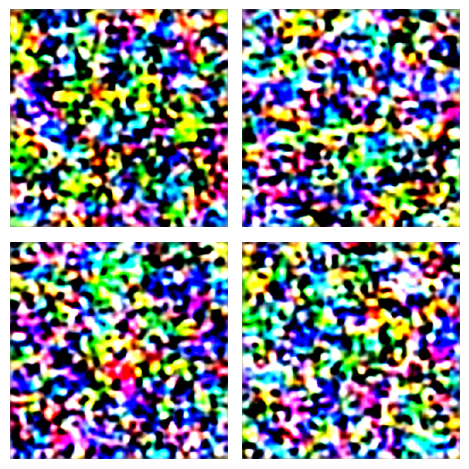

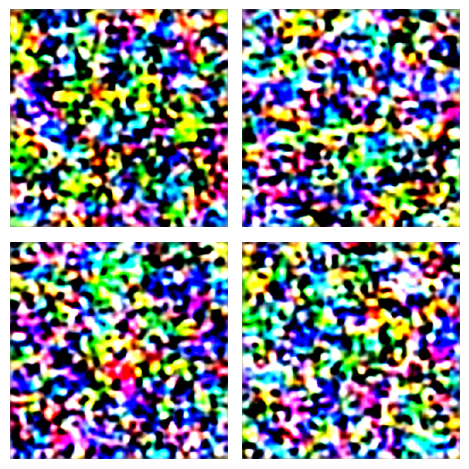

In [5]:
img = dit.generate_uncond_steady(model, vae, diffusion, 4, device, seed=4, show=True);
img1 = dit.generate_uncond_steady(model, vae, diffusion, 4, device, seed=4, show=True);

In [6]:
img == img1

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [8]:
import torch, random, numpy as np, os
from diffusers import DDIMScheduler

def sample_dit_deterministic_4x32_mem_efficient(
    model,
    vae,
    class_labels,                  # LongTensor [B]
    *,
    num_steps=50,
    guidance_scale=4.0,
    seed=12345,
    device="cuda",
    prediction_type="epsilon",
    vae_scaling=0.18215,
    microbatch_size=1,             # <=2 on MPS; 1 is safest
    decode_on_cpu=True             # move z to CPU for VAE decode to avoid MPS OOM
):
    # ----- determinism -----
    # random.seed(seed); np.random.seed(seed)
    # torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    # try:
    #     torch.use_deterministic_algorithms(True, warn_only=True)
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False
    # except Exception:
    #     pass
    # os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":16:8")

    B_total = class_labels.shape[0]
    # use model dtype to avoid upcasting; MPS likes fp16/fp32
    model_dtype = next(model.parameters()).dtype
    # MPS: fp16 usually fine; if you see op-not-implemented, switch to fp32.
    latent_dtype = model_dtype

    # scheduler (deterministic: eta=0)
    scheduler = DDIMScheduler(
        num_train_timesteps=1000,
        beta_start=1e-4,
        beta_end=2e-2,
        beta_schedule="linear",
        clip_sample=False,
    )
    scheduler.config.prediction_type = prediction_type
    scheduler.set_timesteps(num_steps, device=device)
    timesteps = scheduler.timesteps

    # CFG null label (ImageNet: 1000 = null)
    null_token = getattr(model, "num_classes", 1000)

    # VAE memory helpers
    try:
        vae.enable_slicing()
        vae.enable_tiling()
    except Exception:
        pass

    outs = []
    model.eval()
    with torch.inference_mode():
        # process in micro-batches deterministically
        for start in range(0, B_total, microbatch_size):
            end = min(start + microbatch_size, B_total)
            labels_mb = class_labels[start:end].to(device)

            # use a fixed per-sample seed for exact reproducibility
            # (so results don’t depend on microbatching)
            gen = torch.Generator(device=device).manual_seed(seed + start)

            # init latent noise (mb, 4, 32, 32)
            x = torch.randn(end - start, 4, 32, 32, generator=gen, device=device, dtype=latent_dtype)

            null_labels = torch.full_like(labels_mb, fill_value=null_token)

            def fourch(out):
                # model may return 8ch (learned variance); slice to 4
                if isinstance(out, (tuple, list)):
                    out = out[0]
                if out.shape[1] > 4:
                    out = out[:, :4, ...]
                return out

            # diffusion loop
            for t in timesteps:
                t_b = t.repeat(end - start).to(device)
                eps_u = fourch(model(x, t_b, null_labels))
                eps_c = fourch(model(x, t_b, labels_mb))
                eps   = eps_u + guidance_scale * (eps_c - eps_u)
                x = scheduler.step(eps, t, x, eta=0.0, generator=gen).prev_sample

            # decode latents -> RGB in [0,1]
            z = x / vae_scaling
            if decode_on_cpu:
                # free MPS VRAM before decode
                try: torch.mps.empty_cache()
                except Exception: pass
                vae_cpu = vae.to("cpu")
                z_cpu = z.to("cpu", dtype=torch.float32)  # VAE likes fp32 on CPU
                decoded = vae_cpu.decode(z_cpu)
                imgs = decoded.sample if hasattr(decoded, "sample") else (decoded[0] if isinstance(decoded, (tuple, list)) else decoded)
                imgs = (imgs.clamp(-1, 1) + 1) / 2
                # move back to original device if you want
                outs.append(imgs.to(device))
                # keep VAE on CPU to save MPS RAM
            else:
                decoded = vae.decode(z)
                imgs = decoded.sample if hasattr(decoded, "sample") else (decoded[0] if isinstance(decoded, (tuple, list)) else decoded)
                imgs = (imgs.clamp(-1, 1) + 1) / 2
                outs.append(imgs)

            # small cleanup per chunk
            del x, z, decoded
            try: torch.mps.empty_cache()
            except Exception: pass

    imgs_all = torch.cat(outs, dim=0)
    return imgs_all[:B_total]



In [6]:
class_label = torch.full((4,), 1, device=device) * 207

In [9]:
device = "mps"
labels = torch.full((4,), 207, device=device)

imgs = sample_dit_deterministic_4x32_mem_efficient(
    model.to(device), vae, labels,
    num_steps=50, guidance_scale=4.0,
    seed=12345, device=device,
    prediction_type="epsilon",
    microbatch_size=1,        # key for MPS
    decode_on_cpu=True        # key for MPS
)

from torchvision.utils import save_image
save_image(imgs, "dit_xl2_ddim_det_mps_3.png")


In [12]:
import imagenet_maps as im
im.i2w(210, JSON)

'n02100236'